In [1]:

import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       
        pass

print("done!")


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7b3f565fbe20>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



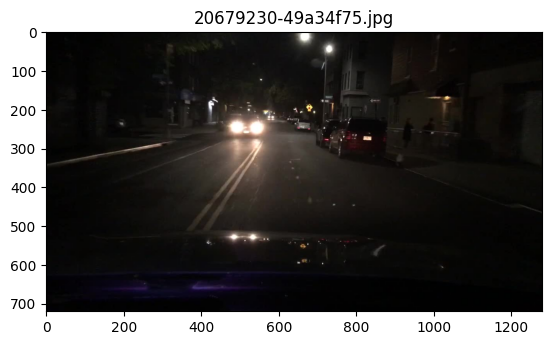

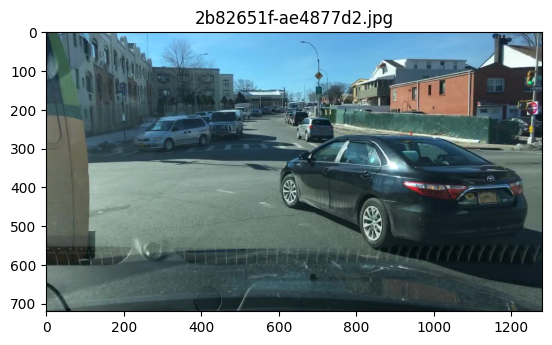

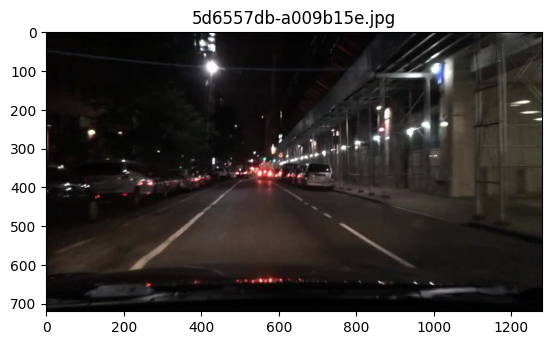

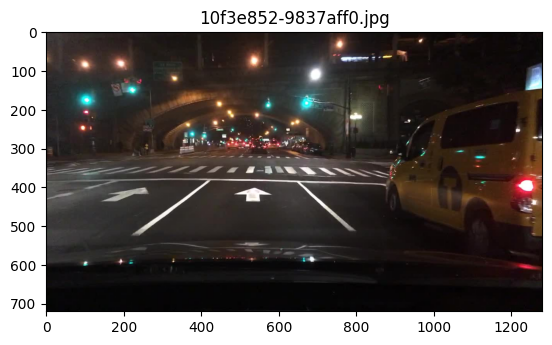

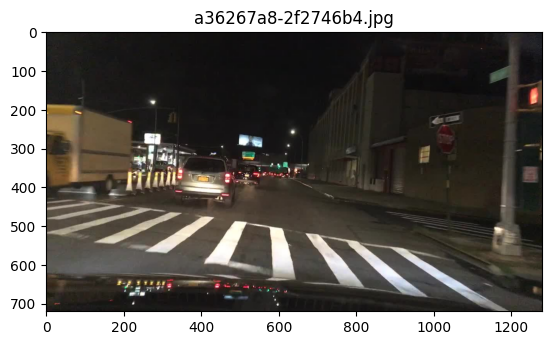

In [4]:
import matplotlib.pyplot as plt

image_dir = '/kaggle/input/bdd100k/train/images'

image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]  


for i in range(5): 
    image_path = os.path.join(image_dir, image_files[i])
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(image_files[i])
    plt.show()

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoProcessor
from PIL import Image
import random


model_name = "google/vit-base-patch16-224-in21k"  


processor = AutoProcessor.from_pretrained(model_name)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [8]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoModel, AutoImageProcessor
import pandas as pd
from PIL import Image
import os


class DynamicWeightedMSELoss(nn.Module):
    def __init__(self):
        super(DynamicWeightedMSELoss, self).__init__()

    def forward(self, predictions, targets, dynamic_weights):
    
        weights = dynamic_weights / torch.sum(dynamic_weights)
        return torch.mean(weights * (predictions - targets) ** 2)


class ImagePairDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, image_dir, transform):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img1_path = os.path.join(self.image_dir, row['Image 1'])
        img2_path = os.path.join(self.image_dir, row['Image 2'])
        similarity_score = row['Similarity']

        if not os.path.exists(img1_path) or not os.path.exists(img2_path):
            raise FileNotFoundError(f"Image not found: {img1_path} or {img2_path}")

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        return {
            "input_ids_1": img1,
            "input_ids_2": img2,
            "similarity_score": torch.tensor(similarity_score, dtype=torch.float32),
        }


class ViTDistanceModel(nn.Module):
    def __init__(self, model_name):
        super(ViTDistanceModel, self).__init__()
        self.vit = AutoModel.from_pretrained(model_name)
        self.linear = nn.Linear(768, 1)

    def forward(self, img1, img2):
        features1 = self.vit(pixel_values=img1).last_hidden_state[:, 0, :]
        features2 = self.vit(pixel_values=img2).last_hidden_state[:, 0, :]
        distance = torch.abs(features1 - features2)
        return self.linear(distance)


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'google/vit-base-patch16-224-in21k'
image_processor = AutoImageProcessor.from_pretrained(model_name)

model = ViTDistanceModel(model_name).to(device)


train_csv = '/kaggle/input/new-train-dataset1/new_train_results_ansh.csv'
val_csv = '/kaggle/input/new-validation-dataset1/new_validation_results_rohit.csv'
train_image_dir = '/kaggle/input/bdd100k/train/images'
val_image_dir = '/kaggle/input/bdd100k/val/images'


def preprocess(image):
    return image_processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)


train_dataset = ImagePairDataset(train_csv, train_image_dir, preprocess)
val_dataset = ImagePairDataset(val_csv, val_image_dir, preprocess)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


criterion = DynamicWeightedMSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)
early_stopping = EarlyStopping(patience=3, min_delta=1e-4)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_ids_1 = batch["input_ids_1"].to(device)
        input_ids_2 = batch["input_ids_2"].to(device)
        distances = batch["similarity_score"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids_1, input_ids_2)

        
        dynamic_weights = 1.0 / (distances + 1e-6)  
        loss = criterion(outputs, distances, dynamic_weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_ids_1 = batch["input_ids_1"].to(device)
            input_ids_2 = batch["input_ids_2"].to(device)
            distances = batch["similarity_score"].to(device)

            outputs = model(input_ids_1, input_ids_2)
           
            dynamic_weights = 1.0 / (distances + 1e-6)
            val_loss += criterion(outputs, distances, dynamic_weights).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/10], Training Loss: 3275.5322
Epoch [1/10], Validation Loss: 1672.2581
Epoch [2/10], Training Loss: 1243.0754
Epoch [2/10], Validation Loss: 878.6680
Epoch [3/10], Training Loss: 953.5270
Epoch [3/10], Validation Loss: 761.0892
Epoch [4/10], Training Loss: 836.6249
Epoch [4/10], Validation Loss: 744.2500
Epoch [5/10], Training Loss: 846.4449
Epoch [5/10], Validation Loss: 803.9315
Epoch [6/10], Training Loss: 842.6865



KeyboardInterrupt

